Check Python version

In [1]:
!python --version

Python 3.8.17


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [4]:
train_df = pd.read_csv(file_name)

In [5]:
train_df.shape

(144, 2)

In [6]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [7]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [9]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [10]:
train_df[target_col] = train_df[target_col].astype(float)

In [11]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

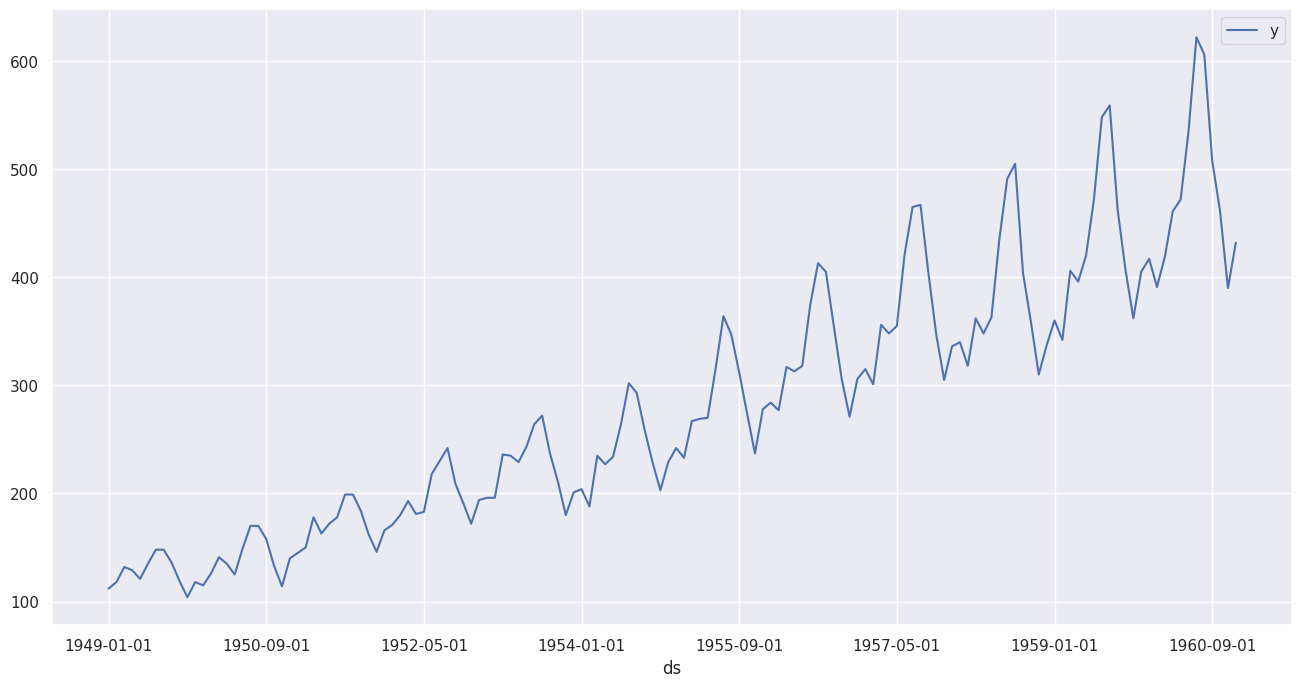

In [12]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [13]:
train_data = []

In [14]:
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [16]:
# Default model request
# model_request = {
#     'type': 'meta_wa',  # 'meta_wa'
#     'scorers': ['smape', 'mape'],
#     'params': {
#         'preprocessors': [
#             {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_autoets'},
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

# Customized model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mape'],
#     'param': {
#         'base_models': [
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoets'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

Train API JSON Payload

In [17]:
api_json = {
    'data': train_data,
    # 'model': model_request  # (optional) can be commented out
}

Build URL

In [18]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [19]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [20]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [21]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

/home/studio-lab-user/.conda/envs/test/lib/python3.8/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil-test.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CPU times: user 22.9 ms, sys: 4.93 ms, total: 27.8 ms
Wall time: 7.44 s


In [22]:
print(response)
train_json_out = response.json()  # dict output
# train_json_out = json.dumps(response.json())  # str output
# train_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

<Response [200]>


In [23]:
train_json_out

{'model': 'AgEBCHHeAABw3gAAZpAAABgAAABhkAAAVRIAAD+AAGVsaZOMb5Rsb4xJk4xnbl+MYQd4k4yMjIx1ZWVscx9Nk4xvKCgpaHWUS3UMYSlkZHJsYWZ0dHNTlG5pcnMKaR+UaYwDYXJyYZSUcjh5YYxhkyiUZGFyaW54dJRyYXJlaR9udHhESX1hYS6MdV9ClHNydIxtk4dteU2UTkqUAZRtLgdyZWMHlAFLjIAPHwDN19/p8vwFDhghKjQ9R09ZYmx1foiRm6Stt7/J0tzlH+74AQsUHScwOUJMVV9ocXuEjpegqbK8xc/Y4ev0/gcQHxkiLDU/SFFbZG53gImTnKWvuMHL1N7n8PoDDBYfKTI7H0VOWGBqc3yGj5miq7W+yNDa4+z2/wkSGyUuOEBKU11mH295gouVnqixusPN1uDp8vwFjE5hlHmUcmWUCW5OhZQYH2NlZV+UZWiFKGCHAf9LjGiUMShLYpRic26UcmVzYZMoB5RoXGiFKHYA4IYAH3SMLnNmTWmGYQUKaAMLdIaBaFWUS4liUmgFjGJWlJSMApRulIGB4Ia3HwCUKGNhaHmGC24TdG5ocU1wY3R0ZW5iY2WUcmlpjHRvEHNlY2V4dGGJX2Nlb19jZXhhYAofaWRkbWyUZZRkZWVuamWULmNlLnNlYylhZQeUiXN1X04fdGyMbmF0c2kXdXaUX3aUX2NlYWQQb3MoAJRoaIxlcmbACh90bWZyZYxvbQeUKGiMlHMGfWxYabBjYehNjECMAZuGcx9ompQRcnR1aGgBQ9mUYOzp7fDz8/Hv7/DsluiFKJQAPwI/QD/gAwDguQ0flHVulIUAqqdPiqyko4qppZWdmrqhiLGSoqC2mYC4s7ofuWaup5lzrayvq6e6fp97rZSpk7KyqZihs7SVpqmAcaEffXpwsKmgq6OqfpOhoJytkYOqorCzdaGig6ujk4OforIfoYWHcIyRmIOanqS1pKOOZHaKh6mjm

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [24]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [25]:
model = train_json_out['model']

Forecast API JSON Payload

In [26]:
api_json = {
    'model': model,
    'predicts': dates
}

Build URL (same as train except for the endpoint)

In [27]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [28]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: user 27.7 ms, sys: 0 ns, total: 27.7 ms
Wall time: 114 ms


/home/studio-lab-user/.conda/envs/test/lib/python3.8/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sybil-test.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [29]:
forecast_json_out = response.json()  # dict output
# forecast_json_out = json.dumps(response.json())  # str output
# forecast_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [30]:
forecast_json_out

{'data': [['1960-12-31T00:00:00', 420.4216160478972],
  ['1961-01-30T00:00:00', 398.08444372370826],
  ['1961-03-01T00:00:00', 447.65902213215537],
  ['1961-03-31T00:00:00', 470.8748350823535],
  ['1961-04-30T00:00:00', 484.0539751669631],
  ['1961-05-30T00:00:00', 565.2277983302522],
  ['1961-06-29T00:00:00', 652.1267840956648],
  ['1961-07-29T00:00:00', 645.6961694311497],
  ['1961-08-28T00:00:00', 543.0927458849617],
  ['1961-09-27T00:00:00', 478.892652304391],
  ['1961-10-27T00:00:00', 400.2572654309118],
  ['1961-11-26T00:00:00', 457.942240982859],
  ['1961-12-26T00:00:00', 470.47103535340074],
  ['1962-01-25T00:00:00', 447.1941857545858],
  ['1962-02-24T00:00:00', 501.139054714192],
  ['1962-03-26T00:00:00', 523.2437089204948],
  ['1962-04-25T00:00:00', 536.6160759114928],
  ['1962-05-25T00:00:00', 622.430597828436],
  ['1962-06-24T00:00:00', 713.3480375240724],
  ['1962-07-24T00:00:00', 706.6827042158111],
  ['1962-08-23T00:00:00', 598.4488596223543],
  ['1962-09-22T00:00:00', 5

Combine forecast dates and output

In [31]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [32]:
forecast_df.shape

(24, 2)

In [33]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [34]:
forecast_df.head()

,ds,y
0,1960-12-31T00:00:00,420.421616
1,1961-01-30T00:00:00,398.084444
2,1961-03-01T00:00:00,447.659022
3,1961-03-31T00:00:00,470.874835
4,1961-04-30T00:00:00,484.053975


In [35]:
forecast_df.tail()

,ds,y
19,1962-07-24T00:00:00,706.682704
20,1962-08-23T00:00:00,598.448860
21,1962-09-22T00:00:00,529.348888
22,1962-10-22T00:00:00,446.454852
23,1962-11-21T00:00:00,507.588502


Plot train and forecast side-by-side

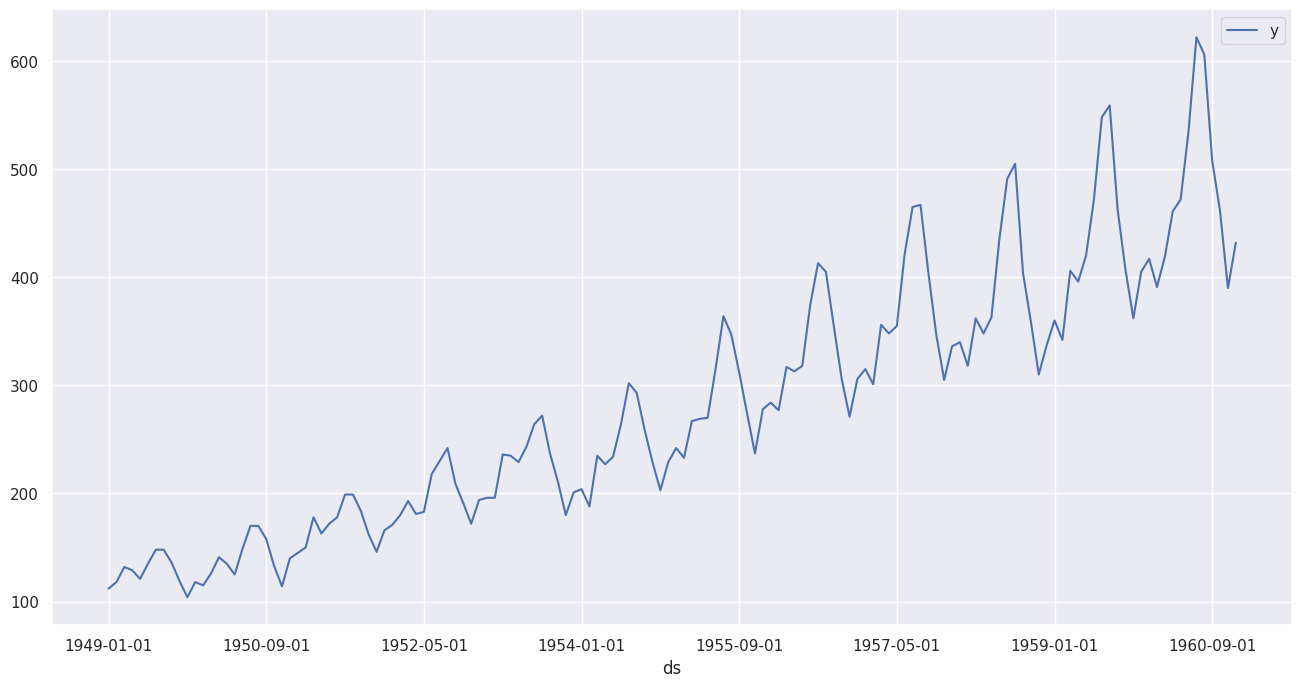

In [36]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

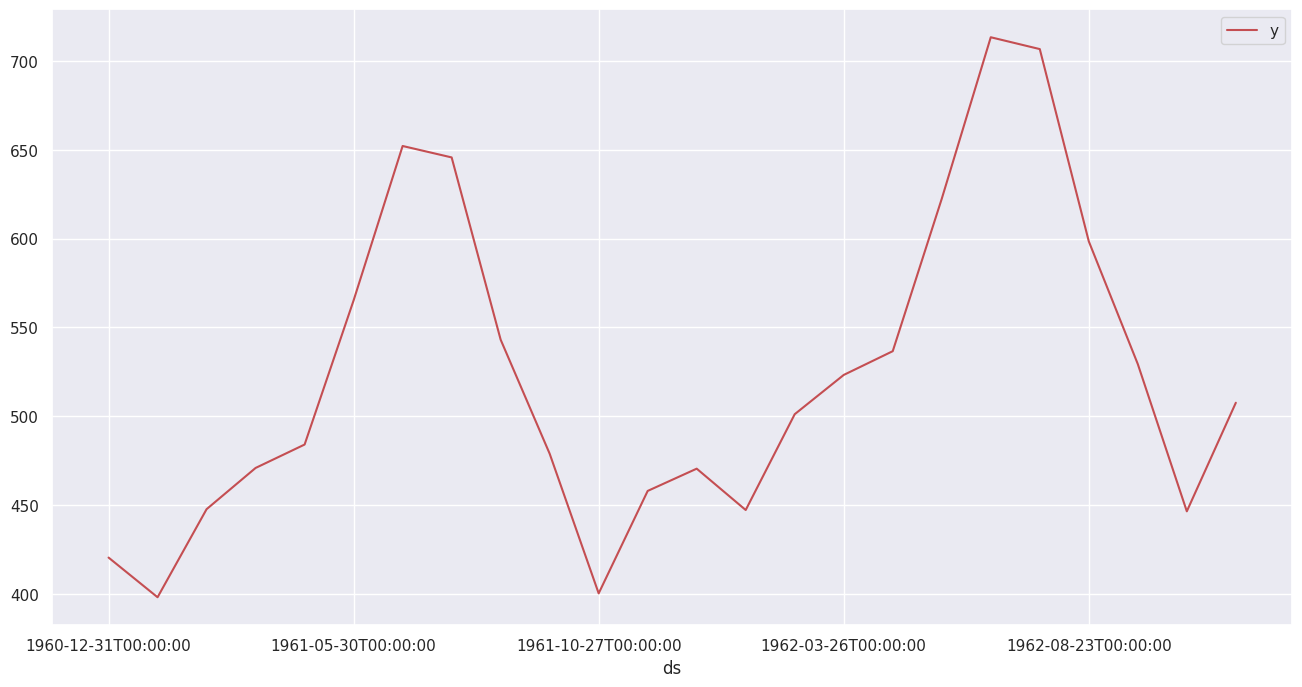

In [37]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and test sets

In [38]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [39]:
df.shape

(168, 3)

In [40]:
df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [41]:
df.tail()

,ds,y,color
163,1962-07-24T00:00:00,706.682704,r
164,1962-08-23T00:00:00,598.448860,r
165,1962-09-22T00:00:00,529.348888,r
166,1962-10-22T00:00:00,446.454852,r
167,1962-11-21T00:00:00,507.588502,r


Plot combined train and test sets with the vertical black line as the cut-off

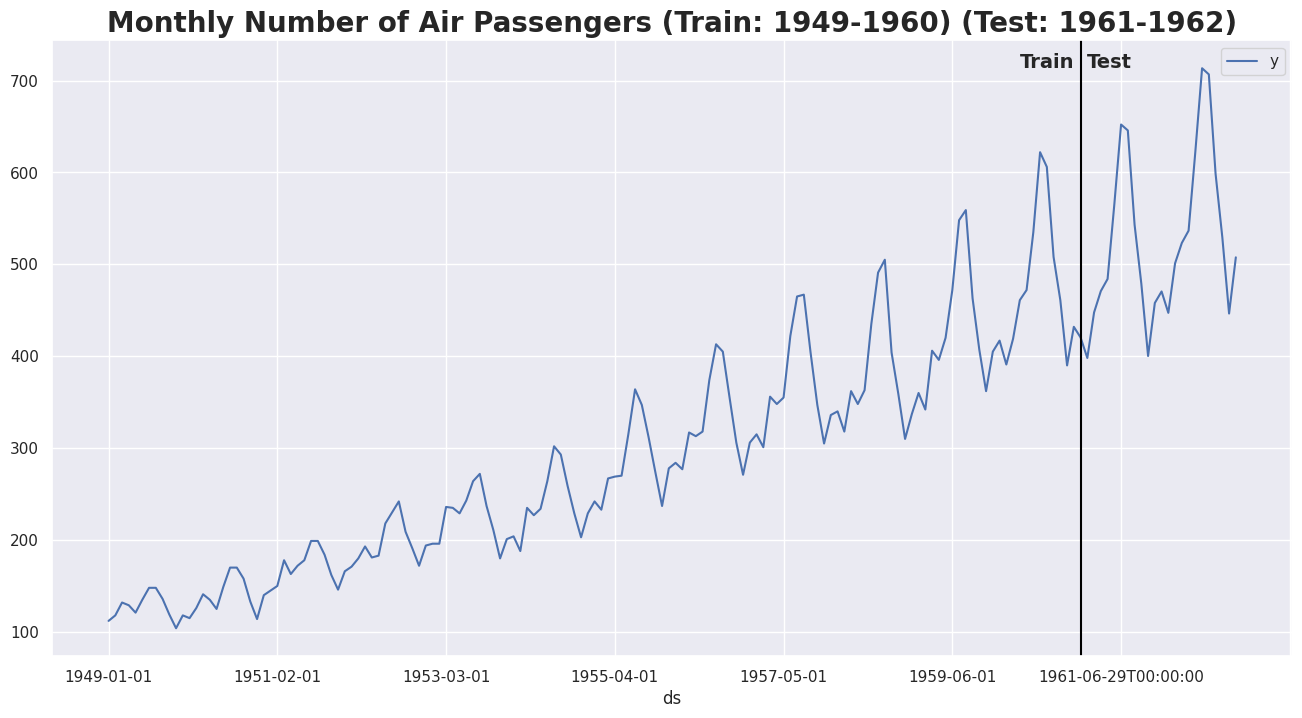

In [42]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Test: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();